# Quantum Data Re-Uploading Unit (QRU) for River Level Prediction

This notebook demonstrates a minimal, functional prototype of a Quantum Data Re-Uploading Unit (QRU) for time-series prediction, applied to river water levels.

**Main objectives:**
- Preprocess and normalize river level data.
- Build and train a simple QRU on sequential data (predict next day's level from previous days).
- Save and visualize training metrics and predictions.

*Note: The QRU is implemented using PennyLane (quantum simulator) and PyTorch as backend optimizer.*


## 1. Data Preprocessing
- Load the river water level dataset.
- Normalize the target variable (water level) to [0, 2π] for quantum encoding.
- Create sliding windows for supervised learning.
- Split data into training and test sets.

import os
import pandas as pd
import numpy as np

# Parameters
seq_length = 3
results_dir = "River_QRU_Demo"
os.makedirs(results_dir, exist_ok=True)

def preprocess_river_data(file_path):
    df = pd.read_csv(file_path, skiprows=2)
    df.columns = ['date', 'wlvalue', 'fvalue']
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['date'])
    df.set_index('date', inplace=True)
    # Normalize water level to [0, 2pi] for quantum encoding
    wl_norm = (df['wlvalue'] - df['wlvalue'].min()) / (df['wlvalue'].max() - df['wlvalue'].min()) * (2 * np.pi)
    return wl_norm.to_frame(name='wlvalue_normalized')

def create_sequences(data, seq_length=3):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i + seq_length, 0].values)
        y.append(data.iloc[i + seq_length, 0])
    return np.array(X), np.array(y)

def split_data(data, test_size=0.2, seq_length=3):
    X, y = create_sequences(data, seq_length=seq_length)
    train_size = int((1 - test_size) * len(X))
    return X[:train_size], y[:train_size], X[train_size:], y[train_size:]

file_path = "data/river_level.csv"  
data = preprocess_river_data(file_path)
X_train, y_train, X_test, y_test = split_data(data, seq_length=seq_length)

import torch
X_train = torch.tensor(X_train, dtype=torch.float64)
y_train = torch.tensor(y_train, dtype=torch.float64)
X_test = torch.tensor(X_test, dtype=torch.float64)
y_test = torch.tensor(y_test, dtype=torch.float64)

print("Train X shape:", X_train.shape, "Train y shape:", y_train.shape)
print("Test X shape:", X_test.shape, "Test y shape:", y_test.shape)

## 2. Quantum Data Re-Uploading Circuit (QRU)

We use a simple quantum circuit that encodes each input value using a set of rotation gates, repeated over several layers (depth).

In [3]:
import pennylane as qml

depth = 5  # Number of re-uploading layers
dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev, interface="torch")
def quantum_circuit_3_param_per_input(params, x, alpha=0.5):
    """
    QRU: Quantum circuit with data re-uploading (single feature per time step).
    - x: input sequence (shape [seq_length])
    - params: trainable parameters
    """
    for i in range(depth):
        for j in range(len(x)):
            qml.RX(params[i][3 * j], wires=0)
            qml.RY(params[i][3 * j + 1] * x[j], wires=0)
            qml.RZ(params[i][3 * j + 2], wires=0)
        # Add coupling and entanglement
        qml.RX(alpha * params[i][3 * len(x)], wires=1)
        qml.CRX(alpha * params[i][3 * len(x) + 1], wires=[1, 0])
    return qml.expval(qml.PauliZ(0))

## 3. Training the QRU

- Use Huber loss for robust regression.
- Accuracy: percentage of predictions within 10% of the true value.
- All metrics are saved progressively for visualization.

In [5]:
nb_epoch = 100
lr = 0.01

def huber_loss(y_pred, y_true, delta=1.0):
    diff = torch.abs(y_pred - y_true)
    loss = torch.where(diff <= delta, 0.5 * diff**2, delta * (diff - 0.5 * delta))
    return torch.mean(loss)

def prediction_accuracy(y_pred, y_true, tolerance=0.1):
    within_tolerance = torch.abs(y_pred - y_true) <= (tolerance * torch.abs(y_true))
    return torch.mean(within_tolerance.float()) * 100

def train_model(X_train, y_train, model, params):
    optimizer = torch.optim.RMSprop([params], lr=lr)
    metrics_file = os.path.join(results_dir, "metrics.csv")
    with open(metrics_file, "w") as f:
        f.write("epoch,loss,accuracy\n")
        f.flush()
    for epoch in range(nb_epoch):
        optimizer.zero_grad()
        y_pred = torch.stack([model(params, x) for x in X_train])
        loss = huber_loss(y_pred, y_train)
        loss.backward()
        optimizer.step()
        accuracy = prediction_accuracy(y_pred, y_train)
        with open(metrics_file, "a") as f:
            f.write(f"{epoch + 1},{loss.item()},{accuracy.item()}\n")
            f.flush()

params = torch.tensor(np.full((depth, 3 * seq_length + 2), 0.5), requires_grad=True, dtype=torch.float64)
train_model(X_train, y_train, quantum_circuit_3_param_per_input, params)

## 4. Saving and Visualizing Results

We save predictions and plot:
- Training loss and accuracy curves
- Predicted vs actual values (for both train and test sets)


In [8]:
def save_predictions_progressive(X, y, model, params, file_prefix):
    predictions_file = os.path.join(results_dir, f"{file_prefix}_predictions.csv")
    with open(predictions_file, "w") as f:
        f.write("true_values,predictions\n")
        f.flush()
    with open(predictions_file, "a") as f:
        for i in range(len(X)):
            prediction = model(params, X[i]).detach().item()
            f.write(f"{y[i].item()},{prediction}\n")
            f.flush()

save_predictions_progressive(X_train, y_train, quantum_circuit_3_param_per_input, params, "train")
save_predictions_progressive(X_test, y_test, quantum_circuit_3_param_per_input, params, "test")

print("Saved predictions for train and test sets.")

Saved predictions for train and test sets.


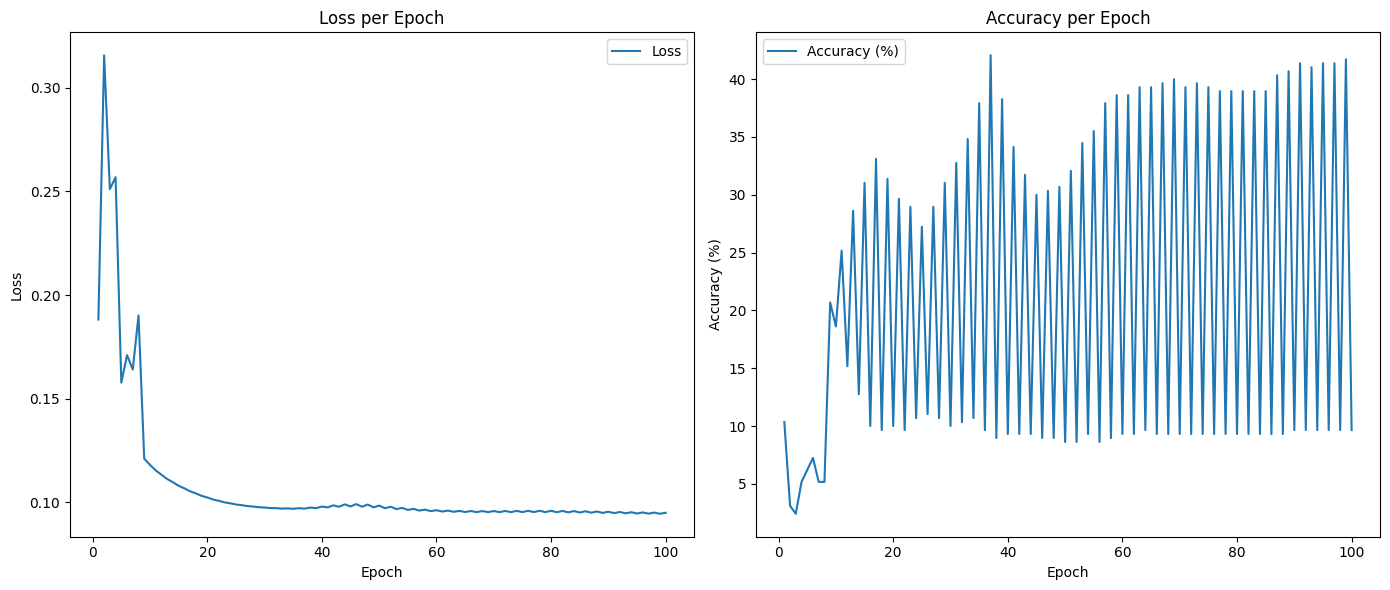

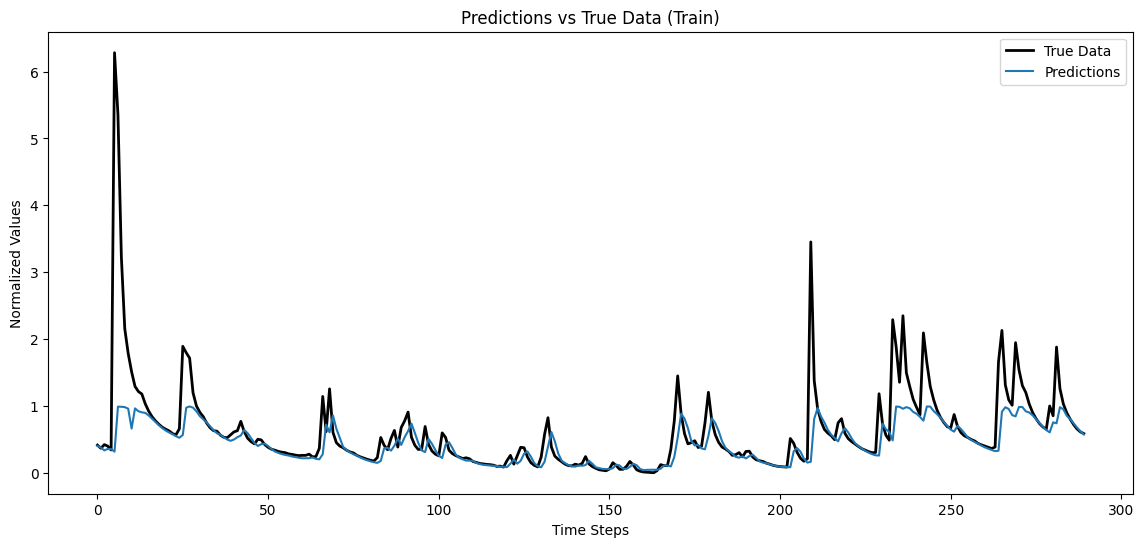

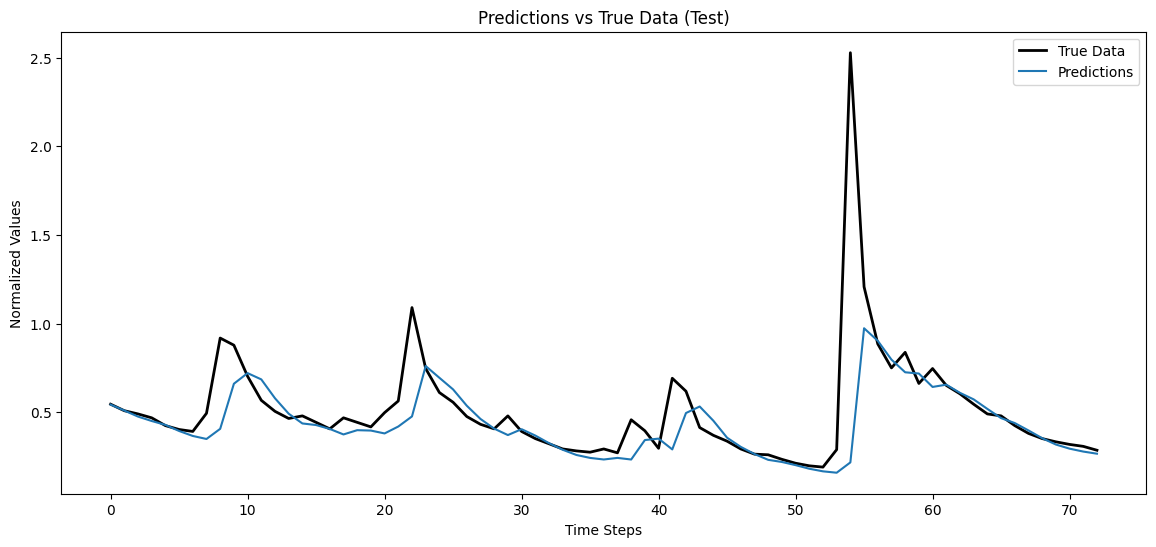

All plots generated and saved.


In [7]:
import matplotlib.pyplot as plt

def visualize_metrics(metrics_file, output_file):
    metrics_df = pd.read_csv(metrics_file)
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(metrics_df["epoch"], metrics_df["loss"], label="Loss")
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(metrics_df["epoch"], metrics_df["accuracy"], label="Accuracy (%)")
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    plt.show()

def visualize_predictions(predictions_file, y_true, output_file, title):
    predictions_df = pd.read_csv(predictions_file)
    true_values = y_true.numpy()
    plt.figure(figsize=(14, 6))
    plt.plot(range(len(true_values)), true_values, label="True Data", color="black", linewidth=2)
    plt.plot(range(len(predictions_df["predictions"])), predictions_df["predictions"], label="Predictions")
    plt.title(title)
    plt.xlabel("Time Steps")
    plt.ylabel("Normalized Values")
    plt.legend()
    plt.savefig(output_file, dpi=300)
    plt.show()

# Visualize
metrics_file = os.path.join(results_dir, "metrics.csv")
metrics_output = os.path.join(results_dir, "loss_accuracy_comparison.png")
visualize_metrics(metrics_file, metrics_output)

train_predictions_file = os.path.join(results_dir, "train_predictions.csv")
train_output = os.path.join(results_dir, "predictions_train_comparison.png")
visualize_predictions(train_predictions_file, y_train, train_output, "Predictions vs True Data (Train)")

test_predictions_file = os.path.join(results_dir, "test_predictions.csv")
test_output = os.path.join(results_dir, "predictions_test_comparison.png")
visualize_predictions(test_predictions_file, y_test, test_output, "Predictions vs True Data (Test)")

print("All plots generated and saved.")

# Conclusion & Next Steps

- This notebook demonstrates a **working prototype** of a quantum data re-uploading model (QRU) for time series forecasting on river levels.
- This serves as a foundation for more advanced models (e.g., combining with classical ML, using multiple features, or moving to real-time/live data).
- Next steps :
    - Integrate real-time data sources (API).
    - Explore micro-insurance automation based on prediction/alert.
    - Prepare to add QAOA or other quantum optimization layers for resource allocation or risk management.

*This simple prototype is a proof-of-concept and starting point for further research and practical development.*
